In [1]:
import pykat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

%matplotlib inline

C:\Users\tvo88\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


                                              ..-
    PyKat 1.1.277         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [365]:
kat_code = '''
%%% FTblock laser
###########################################################################
# Laser and input optics
l L0 30 0.0 0.0 ni
bs jitter 1 0 0 0 ni n0 dump dump
s lmod1 1 n0 n1
# modulators for core interferometer sensing - Advanced LIGO, CQG, 2015 
# http://iopscience.iop.org/article/10.1088/0264-9381/32/7/074001/meta#cqg507871s4-8
# 9MHz (CARM, PRC, SRC loops)
const f1 9099471
const f2 45497355
mod mod1 $f1 0.18 1 pm n1 n2
s lmod2 1 n2 n3
# 45MHz (MICH, SRC loops)
mod mod2 $f2 0.18 1 pm n3 nLaserOut
###########################################################################
%%% FTend laser

%%% FTblock PRC
###########################################################################
s sLaser_PRC 0 nLaserOut nFI1

# Isolator component
dbs FI nFI1 nFI2 nFI3 nREFL
s sFI_PRM 0 nFI3 nPRM1

# PRM
# AR surface
m2 PRMAR 0 40u 0 nPRM1 nPRMs1
# Substrate
s sPRMsub1 0.0737 $nsilica nPRMs1 nPRMs2
# HR surface
m1 PRM 0.03 8.5u $phi_PRM nPRMs2 nPRM2
attr PRM Rc 11.009
# Distance between PRM and PR2
s lp1 16.6107 nPRM2 nPR2a
# PR2
bs1 PR2 250u $Mloss 0 -0.79 nPR2a nPR2b nPOP nAPOP
attr PR2 Rc -4.545
# Distance from PR2 to PR3
s lp2 16.1647 nPR2b nPR3a
# PR3
bs1 PR3 0 $Mloss 0 0.615 nPR3a nPR3b dump12 dump13
attr PR3 Rc 36.027
# Distance from PR3
s lp3 19.5381 nPR3b nPRBS

###########################################################################
%%% FTend PRC

%%% FTblock BS
###########################################################################
# BS beamsplitter
##------------------------------------------------------------ 
## BS 
##                             ^ 
##                  to IMY     |      
##                             |      ,'-.
##                             |     +    `. 
##                        nYBS |   ,'       :'
##      nPR3b                  |  +i1      +
##         ---------------->    ,:._  i2 ,'
##    from the PRC       nPRBS + \  `-. + nXBS
##                           ,' i3\   ,' --------------->
##                          +      \ +     to IMX
##                        ,'     i4.'
##                       `._      ..
##                          `._ ,' |nSRBS
##                             -   |
##                                 |to the SRC
##                                 |
##                                 v
##------------------------------------------------------------
bs1 BS 1.0 0.0 $phi_BS 45 nPRBS nYBS nBSi1 nBSi3
s BSsub1 0.0687 $nsilica nBSi1 nBSi2
s BSsub2 0.0687 $nsilica nBSi3 nBSi4
bs2 BSAR1 50u 0 0 -29.195 nBSi2 dump14 nXBS nPOX
bs2 BSAR2 50u 0 0 29.195 nBSi4 dump15 nSRBS dump16

###########################################################################
%%% FTend BS


%%% FTblock Xarm
###########################################################################

# Distance from beam splitter to X arm input mirror 
s lx1 4.993 nXBS nITMX1a

# Thermal lens correction
lens ITMX_therm $th_f nITMX1a nITMX_th1
s ITMX_th1 0 nITMX_th1 nITMX_th2
lens ITMX_lens inf nITMX_th2 nITMX_th3
s ITMX_th2 0 nITMX_th3 nITMX1

# X arm input mirror
m2 ITMXAR 0 20u 0 nITMX1 nITMXs1 
s ITMXsub 0.2 $nsilica nITMXs1 nITMXs2
m1 ITMX 0.015 $Mloss $phi_ITMX nITMXs2 nITMX2
attr ITMX Rc -1934

# X arm length
s LX $Larm nITMX2 nETMX1

# X arm end mirror
m1 ETMX 5u $Mloss $phi_ETMX nETMX1 nETMXs1
s ETMXsub 0.2 $nsilica nETMXs1 nETMXs2
m2 ETMXAR 0 500u 0 nETMXs2 nPTX 
attr ETMX Rc 2245
attr ETMX mass 40
attr ITMX mass 40

###########################################################################
%%% FTend Xarm


%%% FTblock cavities
###########################################################################
cav cavXARM ITMX nITMX2 ETMX nETMX1
cav cavPRX PRM nPRM2 ITMX nITMXs2
###########################################################################
%%% FTend cavities

%%% FTblock constants
###########################################################################
const nsilica 1.44963098985906
const nTGG 1.954
const nCalcite 1.65846
const Mloss 37.5u
#const Mloss 0.0
const Larm 3994.4692
const fM 36.397884M
const fP 54.596826M
const th_f 34.5k
###########################################################################
%%% FTend constants

%%% FTblock tunings
###########################################################################
const phi_PRM 0.0
const phi_ITMX 0.0
const phi_ETMX 0.0
const phi_BS 0
###########################################################################
%%% FTend tunings

%%% FTblock powers
###########################################################################
pd P_DC_AS nSRBS
pd PIMCtrans nREFL*
pd Px nITMX2
pd Pprc nPRM2
ad prc0 0 nPRM2
ad prcf1 $f1 nPRM2
ad prcf2 $f2 nPRM2
###########################################################################
%%% FTend powers

%%% FTblock errsigs
###########################################################################

# N.B. the I signal refers to most symmetric signal, not greatest slope.
pd1 REFL_f1_I $f1 101 nREFL
pd1 REFL_f1_Q $f1 191 nREFL
pd1 REFL_f2_I $f2 14 nREFL
pd1 REFL_f2_Q $f2 104 nREFL
pd1 POP_f1_I $f1 101 nPOP
pd1 POP_f1_Q $f1 191 nPOP
pd1 POP_f2_I $f2 13 nPOP
pd1 POP_f2_Q $f2 103 nPOP
#pd1 OMClockpd $fdither -1.22 nAS

pd1 POP_18_I 18198942 max nPRM2
pd1 POP_90_I 90994710 max nPRM2

###########################################################################
%%% FTend errsigs

noxaxis
maxtem 2
bp q_in x q nLaserOut
yaxis re:im

'''

def try_it(kat_in):
    result =None
    while result is None:    
        try:
            out = kat_in.run()
            result = 1
        except:
            print("Ran into a pipe error, running again")
            continue

    return out

In [366]:
avg_arm_T = (0.015 + 0.0142)/2

In [367]:
basekat = pykat.finesse.kat() 
basekat.parse(kat_code)

size = 7

Loss = np.linspace(0,80e-6,size)
dRc = np.linspace(0,15e-6,size)

Pprc  = np.ones((Loss.size,dRc.size))
Parm    = np.ones((Loss.size,dRc.size))
POP18 = np.ones((Loss.size,dRc.size))
Pas = np.ones((Loss.size,dRc.size))

In [369]:
for i in range(len(Loss)):
    kat=basekat.deepcopy()
    kat.verbose = False
    orig = kat.ETMX.Rc.value
    
    #Put all the losses in the ETM
    kat.ITMX.L=0

    kat.ETMX.L= Loss[i]
    
    for j in range(len(dRc)):
        kat.ETMX.Rc = (1./orig + dRc[j])**(-1)
        result =None
        while result is None:    
            try:
                out = kat.run()
                result = 1
            except:
                print("Ran into a pipe error, running again")
                continue
        
        Pprc[j][i]  = np.real(out['Pprc'])/kat.L0.P.value
        Parm[j][i]    = np.real(out['Px'])/2
        POP18[j][i] = np.real(out['POP_18_I'])
        Pas[j][i] = np.real(out['P_DC_AS'])

In [370]:
#find mismatch parameters
kat=basekat.deepcopy()
kat.verbose = False
orig = kat.ETMX.Rc.value
mismatch = []

for i in range(len(dRc)):
    
    kat.ETMX.Rc = (1./orig - dRc[i])**(-1)

    kat.cavPRX.enabled = False
    kat.cavXARM.enabled = True
    
    out = try_it(kat)
    q_arm = out['q_in']
    
    kat.cavPRX.enabled = True
    kat.cavXARM.enabled = False
    
    out = try_it(kat)
    q_prx = out['q_in']
    
    print(q_arm,q_prx)

    mismatch.append(1-pykat.BeamParam.overlap(q_arm,q_prx))

mismatch = np.array(mismatch)

(-5.89074277699115+3.07939698084483j) (-5.88682825711863+3.13636787214511j)

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again
(-5.88274707873275+3.1946775775624j) (-5.88682825711863+3.13636787214511j)
(-5.87454253272086+3.30877666627737j) (-5.88682825711863+3.13636787214511j)
(-5.86612084801626+3.42192047496694j) (-5.88682825711863+3.13636787214511j)
(-5.85747328894394+3.53431092103056j) (-5.88682825711863+3.13636787214511j)
(-5.84859064486938+3.64613022724188j) (-5.88682825711863+3.13636787214511j)
(-5.83946319747069+3.7575445754457j) (-5.88682825711863+3.13636787214511j)


In [371]:
mismatch

array([8.44038510e-05, 8.52418719e-05, 7.19203255e-04, 1.90574482e-03,
       3.57808126e-03, 5.68040248e-03, 8.16574908e-03])

In [372]:
def plot_results(Pprc,Parm):
    X,Y = np.meshgrid(Loss*1e6,mismatch*1e2)

    fig = plt.figure(figsize=(10,10),dpi=100)
    cmap = plt.cm.get_cmap("rainbow")

    xlabel = 'Round Trip Loss [PPM]'
    ylabel = 'Mode Mismatch between PRC and ARM [%]'

    ax = fig.add_subplot(221)
    levels = np.linspace(0.0,100,11)
    FS = ax.contourf(X, Y, Pprc,alpha=.25,cmap=cmap,levels=levels)
    CS = ax.contour(X, Y, Pprc, cmap=cmap, levels= levels)
    ax.clabel(CS, fontsize=10, colors='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('Power Recycling Gain')

    ax = fig.add_subplot(222)
    levels = np.linspace(0.0,500,11)
    FS = ax.contourf(X, Y, Parm/1e3,alpha=.25,cmap=cmap,levels=levels)
    CS = ax.contour(X, Y, Parm/1e3, cmap=cmap, levels= levels)
    ax.clabel(CS, fontsize=10, colors='black')
    ax.set_xlabel(xlabel)
    ax.set_title('Arm Build Up [kW]')

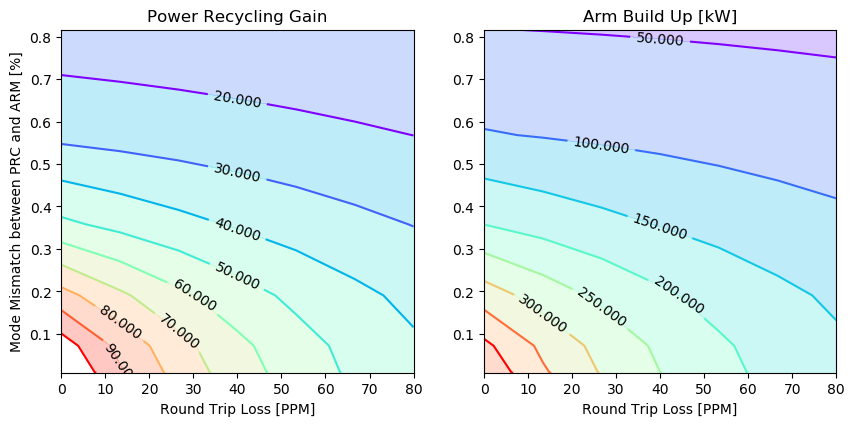

In [373]:
plot_results(Pprc,Parm)


--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
E

C:\Users\tvo88\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,1,'POP 18 Build up')

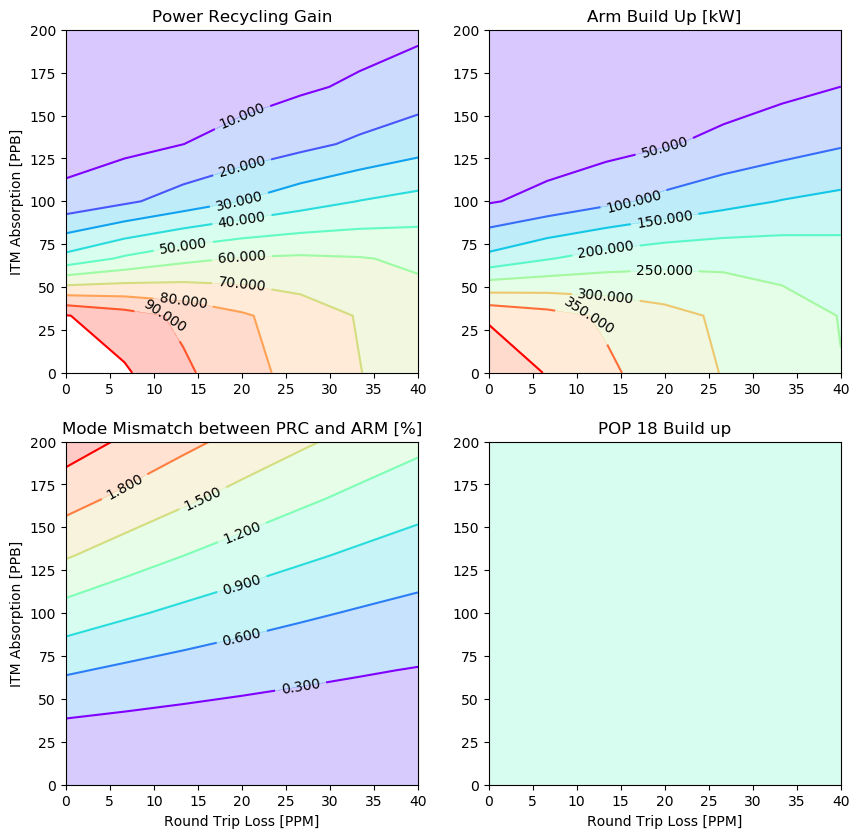

In [381]:
absorption = np.linspace(0,200e-9,size)
Loss = np.linspace(0,40e-6,size)

alpha_sur = -3.60e-5 #diopters per watt
alpha_sub = 4.87e-4 #diopters per watt

mismatch = np.ones((Loss.size,dRc.size))

for i in range(len(Loss)):
    kat=basekat.deepcopy()
    kat.verbose = False
    
    orig_f = kat.ITMX_therm.f.value
    orig_R = kat.ITMX.Rc.value
    
    #Put all the losses in the ITM
    kat.ITMX.L=0
    kat.ETMX.L= Loss[i]
    
    out = try_it(kat)
    
    #arm power with some losses, no mode mismatch yet
    p_arm = np.real(out['Px'])
    

    # Now the mode mismatch is proportional to the change in focal length of the ITM substrate as well
    # as the radius of curvature of the input test mass, I expect the latter to be small.
    for j in range(len(absorption)):
        dRoc = p_arm * alpha_sur * absorption[j]
        dFoc = p_arm * alpha_sub * absorption[j]
        
        kat.ITMX_therm.f = (1./orig_f + dFoc )**(-1)
        kat.ITMX.Rc      = (1./orig_R + dRoc )**(-1)

        # Run with new parameters
        out = try_it(kat)
        #out = kat.run()
        
        Pprc[j][i]  = np.real(out['Pprc'])/kat.L0.P.value
        Parm[j][i]    = np.real(out['Px'])/2
        POP18[j][i] = np.real(out['POP_18_I'])
        Pas[j][i] = np.real(out['P_DC_AS'])
    
        #calculate the amount of mode mismatch per absorption, let Finesse do the hard work!
        
        kat.cavPRX.enabled = False
        kat.cavXARM.enabled = True

        out = try_it(kat)
        #out = kat.run()
        q_arm = out['q_in']

        kat.cavPRX.enabled = True
        kat.cavXARM.enabled = False

        out = try_it(kat)
        q_prx = out['q_in']

        mismatch[j][i]= 1-pykat.BeamParam.overlap(q_arm,q_prx)
        
        ## Turn the cavities back on!
        kat.cavPRX.enabled = True
        kat.cavXARM.enabled = True

X,Y = np.meshgrid(Loss*1e6,absorption*1e9)


### PLot
fig = plt.figure(figsize=(10,10),dpi=100)
cmap = plt.cm.get_cmap("rainbow")

xlabel = 'Round Trip Loss [PPM]'
ylabel = 'ITM Absorption [PPB]'

ax = fig.add_subplot(221)
levels = np.linspace(0.0,100,11)
FS = ax.contourf(X, Y, Pprc,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y, Pprc, cmap=cmap, levels= levels)
ax.clabel(CS, fontsize=10, colors='black')
#ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('Power Recycling Gain')

ax = fig.add_subplot(222)
levels = np.linspace(0.0,500,11)
FS = ax.contourf(X, Y, Parm/1e3,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y, Parm/1e3, cmap=cmap, levels= levels)
ax.clabel(CS, fontsize=10, colors='black')
#ax.set_xlabel(xlabel)
ax.set_title('Arm Build Up [kW]')


ax = fig.add_subplot(223)
levels = np.linspace(0.0,2.0,11)
#FS = ax.contourf(X, Y, mismatch*100,alpha=.25,cmap=cmap,levels=levels)
#CS = ax.contour(X, Y, mismatch*100, cmap=cmap,levels=levels)

FS = ax.contourf(X, Y, mismatch*100,alpha=.25,cmap=cmap)
CS = ax.contour(X, Y, mismatch*100, cmap=cmap)
ax.clabel(CS, fontsize=10, colors='black')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('Mode Mismatch between PRC and ARM [%]')

import matplotlib.ticker as ticker
ax = fig.add_subplot(224)
levels = np.linspace(0.0,1.0,11)
FS = ax.contourf(X, Y,Pas,alpha=.25,cmap=cmap)
CS = ax.contour(X, Y,Pas, cmap=cmap)

#fmt = ticker.LogFormatterMathtext()
#fmt.create_dummy_axis()
ax.clabel(CS, fontsize=10, colors='black')

ax.set_xlabel(xlabel)
ax.set_title('POP 18 Build up')


--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again


C:\Users\tvo88\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,1,'POP 18 Build up')

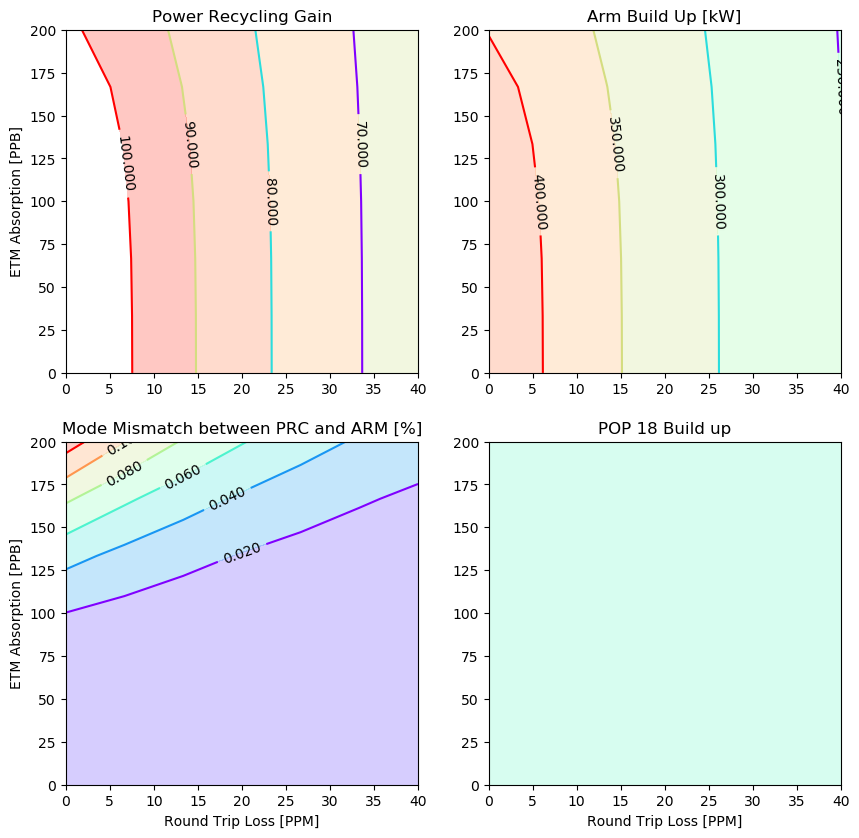

In [382]:
absorption = np.linspace(0,200e-9,size)
Loss = np.linspace(0,40e-6,size)

alpha_sur = -3.60e-5 #diopters per watt
alpha_sub = 4.87e-4 #diopters per watt

mismatch = np.ones((Loss.size,dRc.size))

for i in range(len(Loss)):
    kat=basekat.deepcopy()
    kat.verbose = False
    
    orig_R = kat.ETMX.Rc.value
    
    #Put all the losses in the ITM
    kat.ITMX.L=0
    kat.ETMX.L= Loss[i]
    
    out = try_it(kat)
    
    #arm power with some losses, no mode mismatch yet
    p_arm = np.real(out['Px'])
    

    # Now the mode mismatch is proportional to the change in focal length of the ITM substrate as well
    # as the radius of curvature of the input test mass, I expect the latter to be small.
    for j in range(len(absorption)):
        dRoc = p_arm * alpha_sur * absorption[j]
        dFoc = p_arm * alpha_sub * absorption[j]
        
        #kat.ITMX_therm.f = (1./orig_f + dFoc )**(-1)
        kat.ETMX.Rc      = (1./orig_R + dRoc )**(-1)

        # Run with new parameters
        out = try_it(kat)
        #out = kat.run()
        
        Pprc[j][i]  = np.real(out['Pprc'])/kat.L0.P.value
        Parm[j][i]    = np.real(out['Px'])/2
        POP18[j][i] = np.real(out['POP_18_I'])
        Pas[j][i] = np.real(out['P_DC_AS'])
    
        #calculate the amount of mode mismatch per absorption, let Finesse do the hard work!
        
        kat.cavPRX.enabled = False
        kat.cavXARM.enabled = True

        out = try_it(kat)
        #out = kat.run()
        q_arm = out['q_in']

        kat.cavPRX.enabled = True
        kat.cavXARM.enabled = False

        out = try_it(kat)
        q_prx = out['q_in']

        mismatch[j][i]= 1-pykat.BeamParam.overlap(q_arm,q_prx)
        
        ## Turn the cavities back on!
        kat.cavPRX.enabled = True
        kat.cavXARM.enabled = True

X,Y = np.meshgrid(Loss*1e6,absorption*1e9)


### PLot
fig = plt.figure(figsize=(10,10),dpi=100)
cmap = plt.cm.get_cmap("rainbow")

xlabel = 'Round Trip Loss [PPM]'
ylabel = 'ETM Absorption [PPB]'

ax = fig.add_subplot(221)
levels = np.linspace(0.0,100,11)
FS = ax.contourf(X, Y, Pprc,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y, Pprc, cmap=cmap, levels= levels)
ax.clabel(CS, fontsize=10, colors='black')
#ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('Power Recycling Gain')

ax = fig.add_subplot(222)
levels = np.linspace(0.0,500,11)
FS = ax.contourf(X, Y, Parm/1e3,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y, Parm/1e3, cmap=cmap, levels= levels)
ax.clabel(CS, fontsize=10, colors='black')
#ax.set_xlabel(xlabel)
ax.set_title('Arm Build Up [kW]')


ax = fig.add_subplot(223)
levels = np.linspace(0.0,2.0,11)
#FS = ax.contourf(X, Y, mismatch*100,alpha=.25,cmap=cmap,levels=levels)
#CS = ax.contour(X, Y, mismatch*100, cmap=cmap,levels=levels)

FS = ax.contourf(X, Y, mismatch*100,alpha=.25,cmap=cmap)
CS = ax.contour(X, Y, mismatch*100, cmap=cmap)
ax.clabel(CS, fontsize=10, colors='black')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title('Mode Mismatch between PRC and ARM [%]')

import matplotlib.ticker as ticker
ax = fig.add_subplot(224)
levels = np.linspace(0.0,1.0,11)
FS = ax.contourf(X, Y,Pas,alpha=.25,cmap=cmap)
CS = ax.contour(X, Y,Pas, cmap=cmap)

#fmt = ticker.LogFormatterMathtext()
#fmt.create_dummy_axis()
ax.clabel(CS, fontsize=10, colors='black')

ax.set_xlabel(xlabel)
ax.set_title('POP 18 Build up')